In [1]:
!pip install arch
from arch import arch_model
import numpy as np
import pandas as pd



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 24.0 MB/s eta 0:00:00


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf

In [3]:
df = yf.download("TSLA", start="2018-01-01", end="2024-12-31", progress=False)
prices = df["Close"].asfreq("B").ffill()

/tmp/ipython-input-348495536.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("TSLA", start="2018-01-01", end="2024-12-31", progress=False)


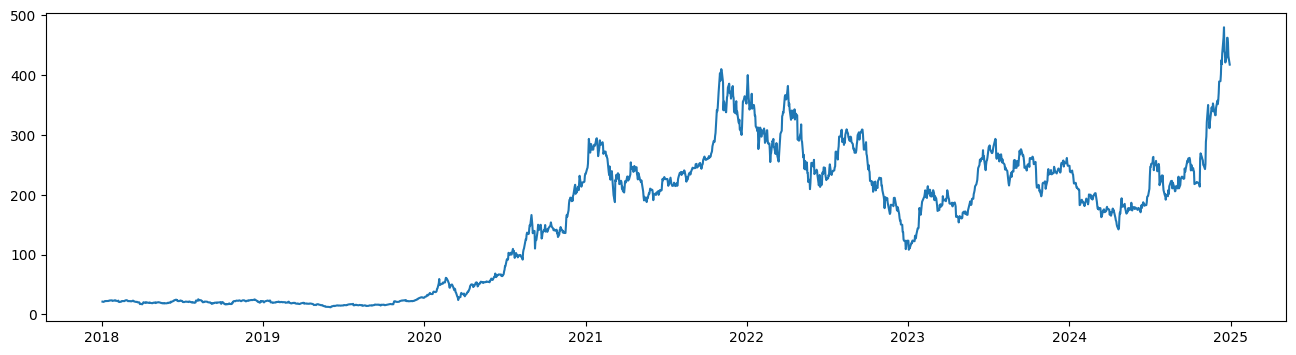

In [4]:
plt.figure(figsize=(16,4))
plt.plot(prices)

In [6]:
from statsmodels.tsa.stattools import adfuller
adfuller(prices)

(np.float64(-1.011042803150675),
 np.float64(0.7492154145374464),
 10,
 1814,
 {'1%': np.float64(-3.4339600207952796),
  '5%': np.float64(-2.863134623063046),
  '10%': np.float64(-2.5676189242070433)},
 np.float64(12296.07089058333))

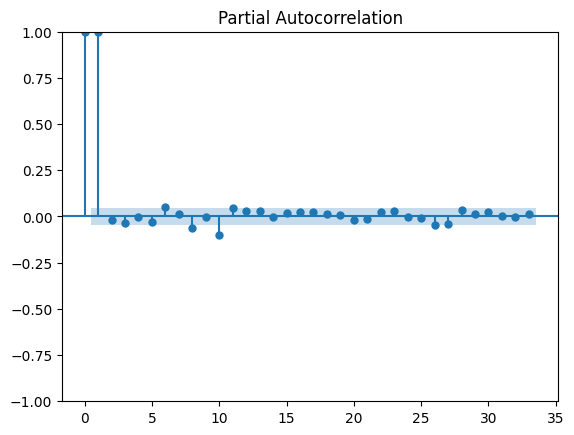

In [8]:
pacf=plot_pacf(prices)

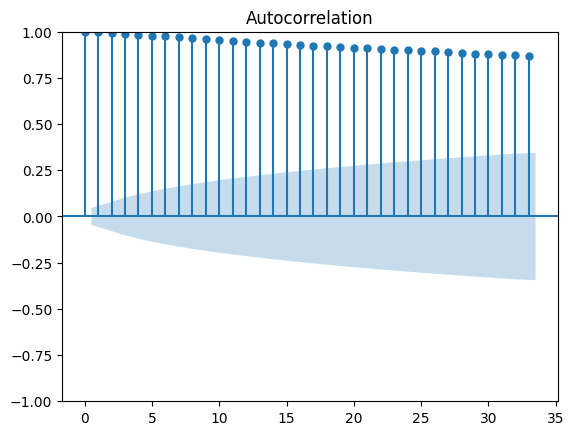

In [9]:
acf=plot_acf(prices)

In [63]:
train_size = int(len(prices) * 0.8)
train = prices.iloc[:train_size]
test = prices.iloc[train_size:,0]

In [64]:
#i am using rolling rediction on the historical data
history = train.copy()
rolling_preds = []

for date in test.index:
    model = SARIMAX(
        history,
        order=(1,1,1),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fit = model.fit()

    pred = fit.forecast(1)
    rolling_preds.append(pred.iloc[0])

    history.loc[date] = test.loc[date]

rolling_preds = pd.Series(rolling_preds, index=test.index)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dat

In [65]:
rolling_preds

,0
Date,
2023-08-08,251.532832
2023-08-09,249.761368
2023-08-10,242.459997
2023-08-11,245.215558
2023-08-14,242.753857
...,...
2024-12-24,430.010033
2024-12-25,462.003459
2024-12-26,462.437485


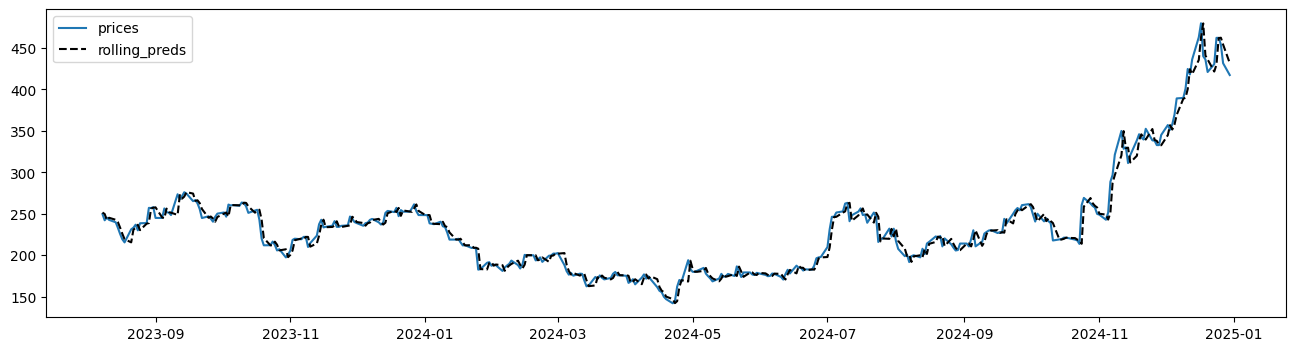

In [66]:

import matplotlib.pyplot as plt
from datetime import datetime
plt.figure(figsize=(16,4))
plt.plot(prices[train_size:])
plt.plot(rolling_preds,ls='--',color='k')
plt.legend(['prices','rolling_preds'])



In [67]:
final_model = SARIMAX(history,
    order=(1,1,1),
    enforce_stationarity=False,
    enforce_invertibility=False
)

fit= final_model.fit()
future_preds= fit.forecast(7)
forecast_result=fit.get_forecast(steps=7)
forecast_mean=forecast_result.predicted_mean
conf_int=forecast_result.conf_int()

future_preds

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


,predicted_mean
2024-12-31,417.077668
2025-01-01,417.393691
2025-01-02,417.093180
2025-01-03,417.378941
2025-01-06,417.107207
2025-01-07,417.365603
2025-01-08,417.119890


In [68]:
from sklearn.metrics import mean_absolute_error , mean_squared_error
mae=mean_absolute_error(prices[train_size:],rolling_preds)
mse=mean_squared_error(prices[train_size:],rolling_preds)
rmse=np.sqrt(mse)
print(mae)
print(rmse)

6.12903856488135
9.062101842563557


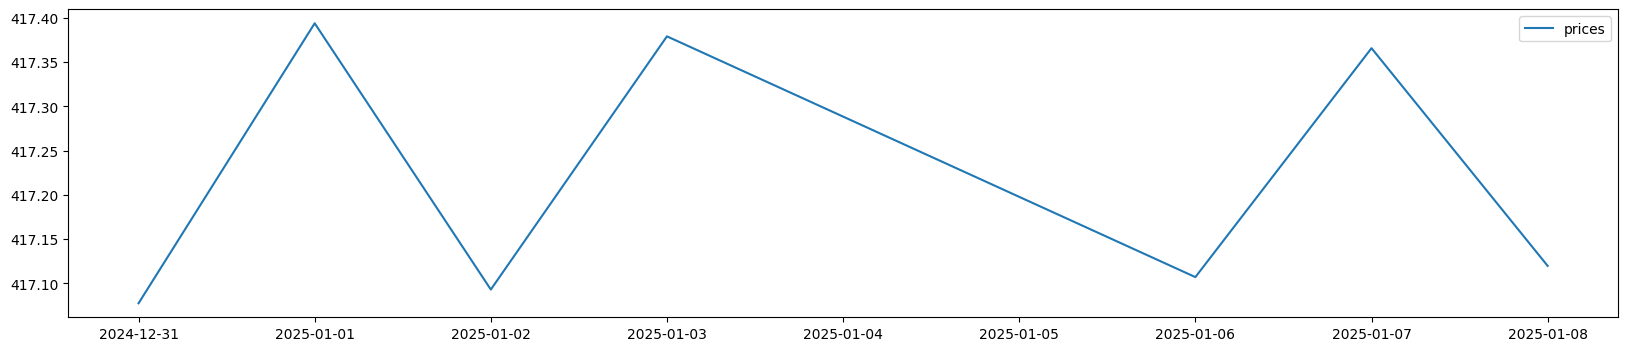

In [69]:
plt.figure(figsize=(20,4))
plt.plot(future_preds)
plt.legend(['prices','rolling_preds'])


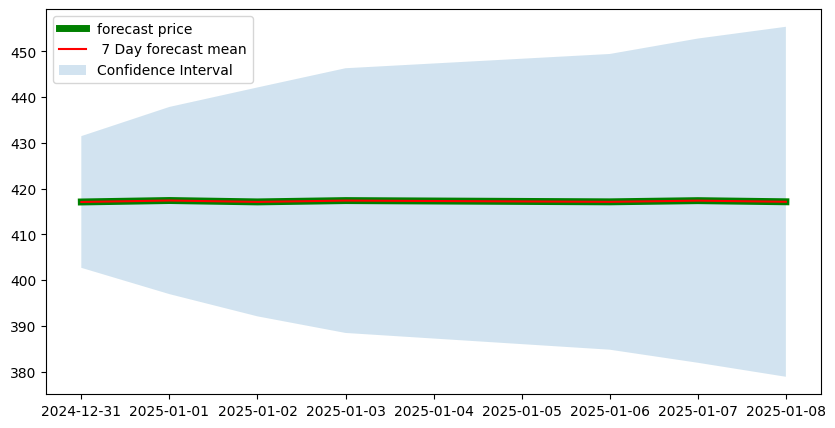

In [48]:
plt.figure(figsize=(10,5))
plt.plot(future_preds ,label="forecast price", color="green",lw=5)
plt.plot(forecast_mean , label=" 7 Day forecast mean" , color="red")
plt.fill_between(conf_int.index,
                 conf_int.iloc[:,0],
                 conf_int.iloc[:,1],
                 alpha=0.2,
                 label="Confidence Interval")
plt.legend()



In [70]:
residuals=rolling_preds-test
residuals

,0
Date,
2023-08-08,1.832835
2023-08-09,7.571365
2023-08-10,-2.879999
2023-08-11,2.565564
2023-08-14,2.993863
...,...
2024-12-24,-32.269965
2024-12-25,-0.276540
2024-12-26,8.307480


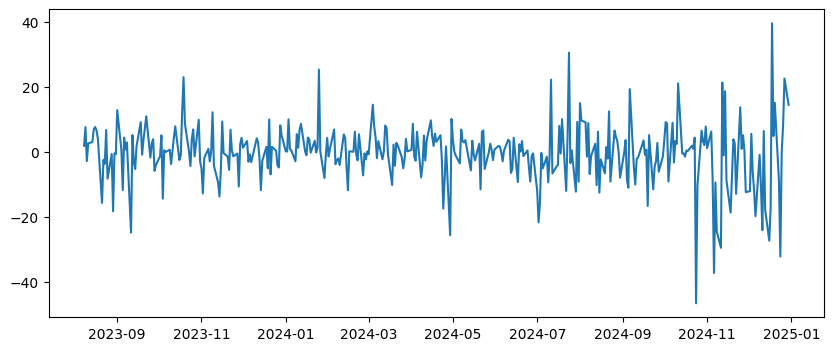

In [72]:
plt.figure(figsize=(10,4))
plt.plot(residuals)

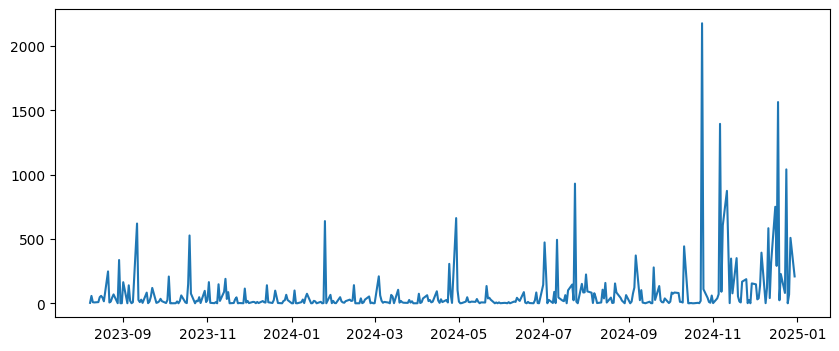

In [74]:
plt.figure(figsize=(10,4))
plt.plot(residuals**2)

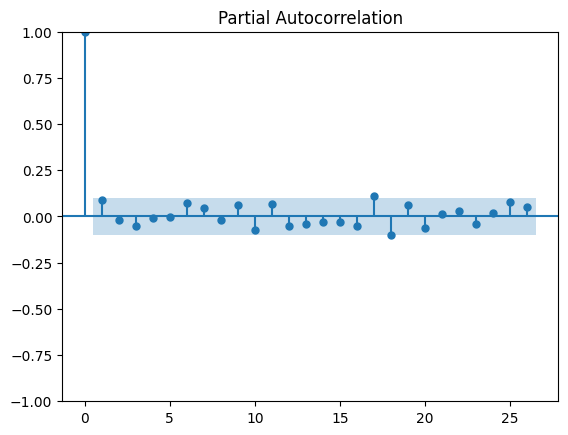

In [89]:
pacf=plot_pacf(residuals)

In [113]:
from arch import arch_model
model = arch_model(
    residuals,
    vol='Garch',
    p=5,
    q=2,
    mean='Zero'
)
garch_fit=model.fit(disp='off')
print(garch_fit.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.003
Vol Model:                      GARCH   Log-Likelihood:               -1287.51
Distribution:                  Normal   AIC:                           2591.02
Method:            Maximum Likelihood   BIC:                           2622.21
                                        No. Observations:                  365
Date:                Wed, Jan 28 2026   Df Residuals:                      365
Time:                        19:04:27   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          4.3897     11.185      0.392      0.695 

In [114]:
from statsmodels.stats.diagnostic import het_arch
std_resid=garch_fit.std_resid
arch_test_results=het_arch(std_resid) # Renamed variable to avoid conflict
print(arch_test_results)

(np.float64(16.726108241922464), np.float64(0.08064849307398039), 1.700923829893511, 0.0790528427530113)


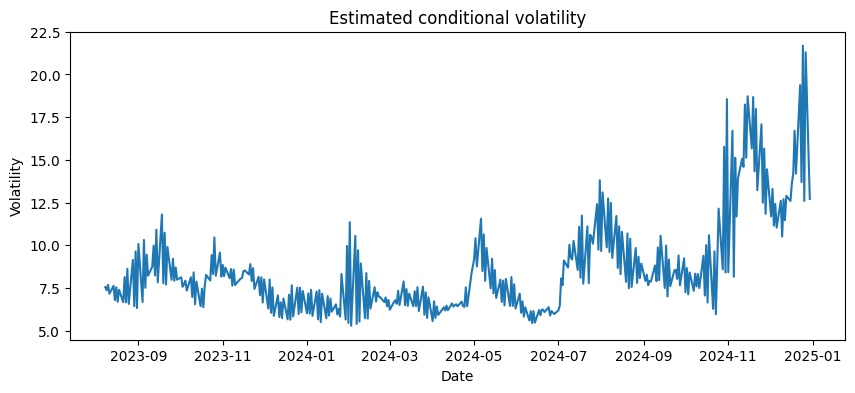

In [115]:
plt.figure(figsize=(10,4))
plt.plot(garch_fit.conditional_volatility) # standard deviation
plt.title('Estimated conditional volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.show()